# Hate Speech Detector 2.0
---
**Vectorizers quality analysis with application of Simple Machine Learning classifier** (part 2/2)

1. Load lemmatized tweets.
2. Select severe vectorizers to analysis.
3. Select the best Simple ML Classifier from the previous task (**SGD with l2 penalty**).
4. Perform multilabel classification task using different vectorizers.
5. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
6. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.vectorizers.TextTFIDFVectorizer import TextTFIDFVectorizer
from src.vectorizers.TextPretrainedFTVectorizer import TextPretrainedFTVectorizer
from src.vectorizers.TextOwnTrainedFTVectorizer import TextOwnTrainedFTVectorizer
from src.vectorizers.TextPretrainedBERTVectorizer import TextPretrainedBERTVectorizer
from src.vectorizers.TextOwnTrainedBERTVectorizer import TextOwnTrainedBERTVectorizer

from src.classifiers.SimpleMLVectorClassifier import SimpleMLVectorClassifier
from src.dataframes.utils import classes, combine_row_wisely, shuffle_dataframe
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import (LABELS,
                           DUPLICATED_PATH, LEMMAS_PATH,
                           COMBINED_TESTONLY_PATH, LEMMAS_TESTONLY_PATH,
                           SMLCV_CHART_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
plt.style.use('ggplot')

## Data loading

### Classes

In [4]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


In [5]:
df_test_classes = pd.read_csv(COMBINED_TESTONLY_PATH)[LABELS]
df_test_classes = classes(df_test_classes, convert_null=True)
df_test_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [6]:
df_lemmatized = pd.read_csv(DUPLICATED_PATH)[['tweet']]
df_lemmatized.head(2)

,tweet
0,w czwartek muszę poprawić sądy i trybunały
1,Żale Nałęcza i riposta Macierewicza: Pan był w...


In [7]:
df_test_lemmatized = pd.read_csv(COMBINED_TESTONLY_PATH)[['tweet']]
df_test_lemmatized.head(2)

,tweet
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s..."
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...


### Combined data

In [8]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
14767,"Dlaczego media nie rozumieją sądów, a sądy nie...",0,0,0,0,0,0,0
7636,"to, że sądy i prokuratura to DNO, to żadna ta...",0,0,0,0,0,0,0


In [9]:
df_test_data = combine_row_wisely([df_test_lemmatized, df_test_classes])
df_test_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s...",0,0,0,0,0,0,0
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...,0,0,0,0,0,0,0


## Models implementation and testing

In [10]:
VEC_CLASSES = [TextTFIDFVectorizer, TextTFIDFVectorizer,
               TextPretrainedFTVectorizer, TextOwnTrainedFTVectorizer, TextOwnTrainedFTVectorizer,
               TextPretrainedBERTVectorizer, TextOwnTrainedBERTVectorizer,
               TextPretrainedBERTVectorizer, TextOwnTrainedBERTVectorizer,
              ]
VEC_KWARGS = [{'model_type': 'tf', 'short_name': 'TF'}, {'model_type': 'tfidf', 'short_name': 'TFIDF'},
              {}, {'model_type': 'u', 'short_name': 'unsuper'}, {'model_type': 's', 'short_name': 'super'},
              {'model_type': 'bert', 'short_name': 'BERT'},
              {'model_type': 'bert', 'short_name': 'BERT'},
              {'model_type': 'roberta', 'short_name': 'RoBERTa'},
              {'model_type': 'roberta', 'short_name': 'RoBERTa'},
             ]
VEC_LABELS = ['TF', 'TFIDF',
              'FT-pret', 'FT-mtr-u', 'FT-mtr-s',
              'BERT-pret', 'BERT-retr',
              'RoBERTa-pret', 'RoBERTa-retr',
             ]

In [11]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

X_test_data = df_test_data.drop(LABELS, axis=1).values
y_test_data = df_test_data[LABELS].values

y_preds = list([])

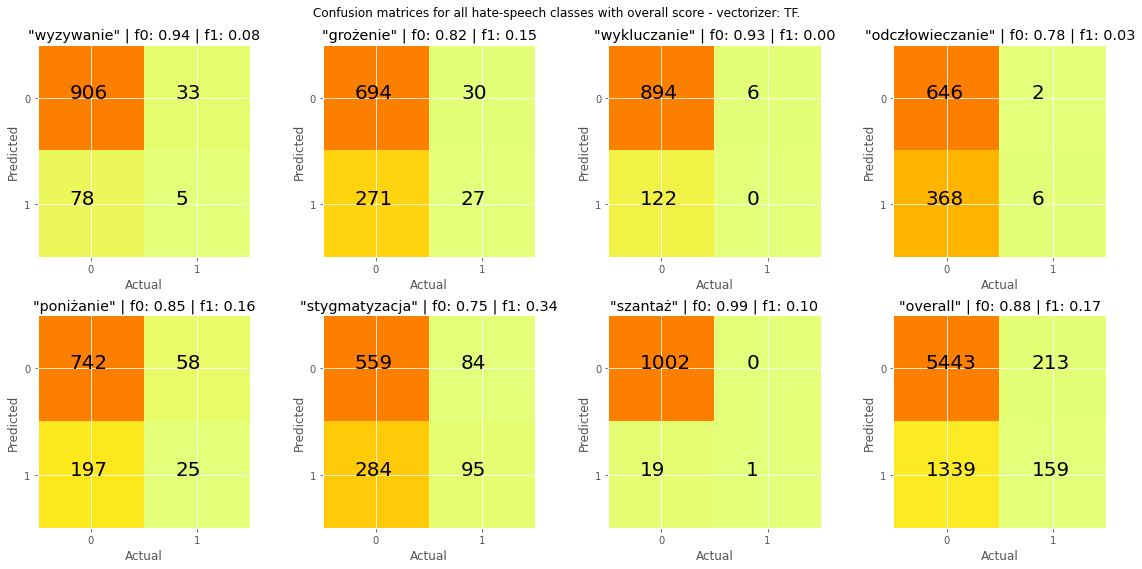

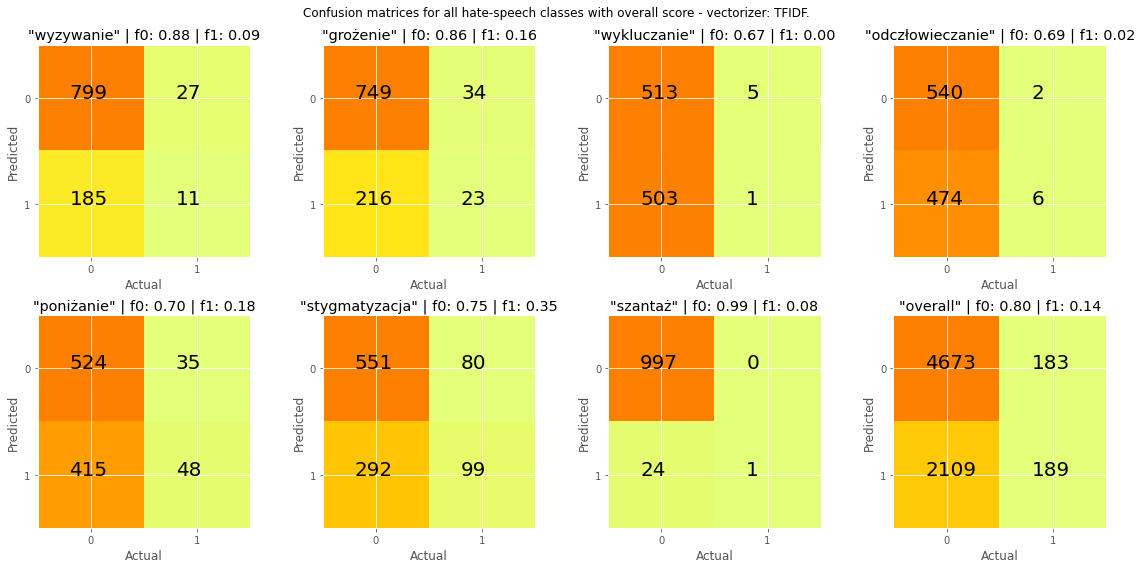

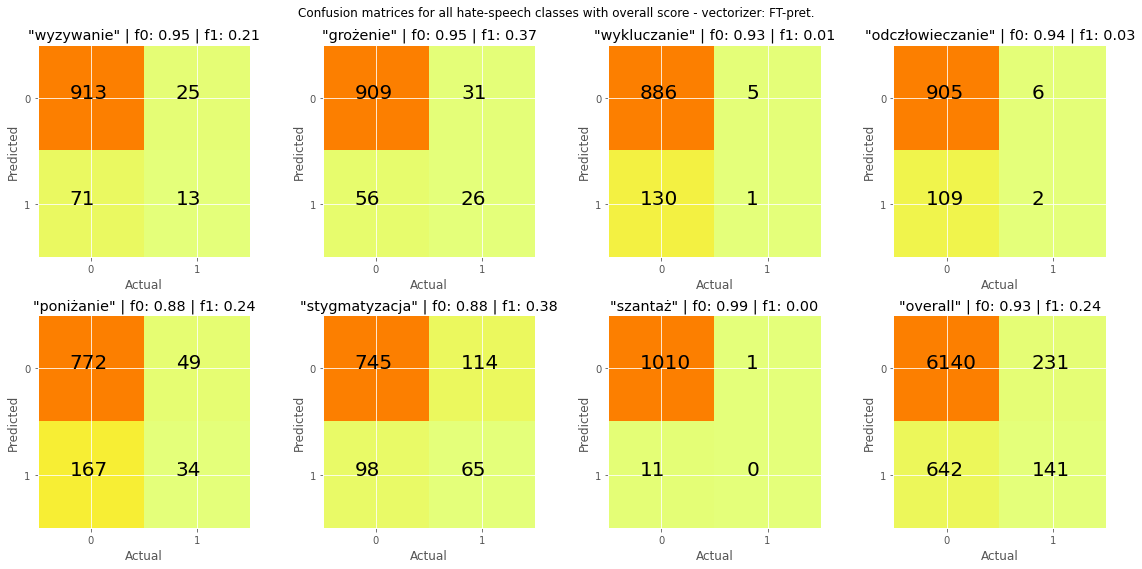

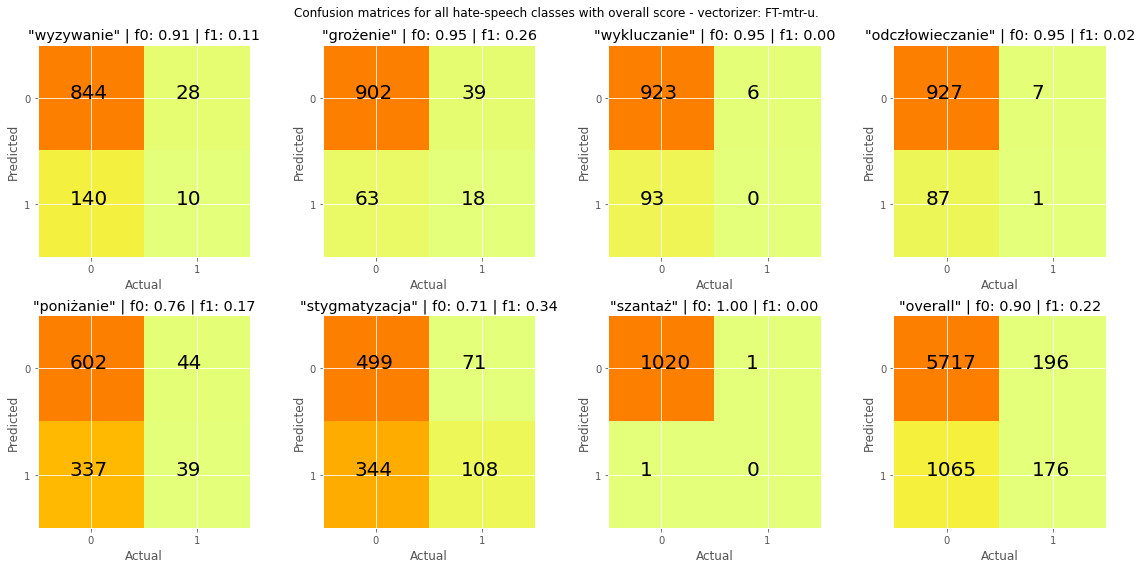

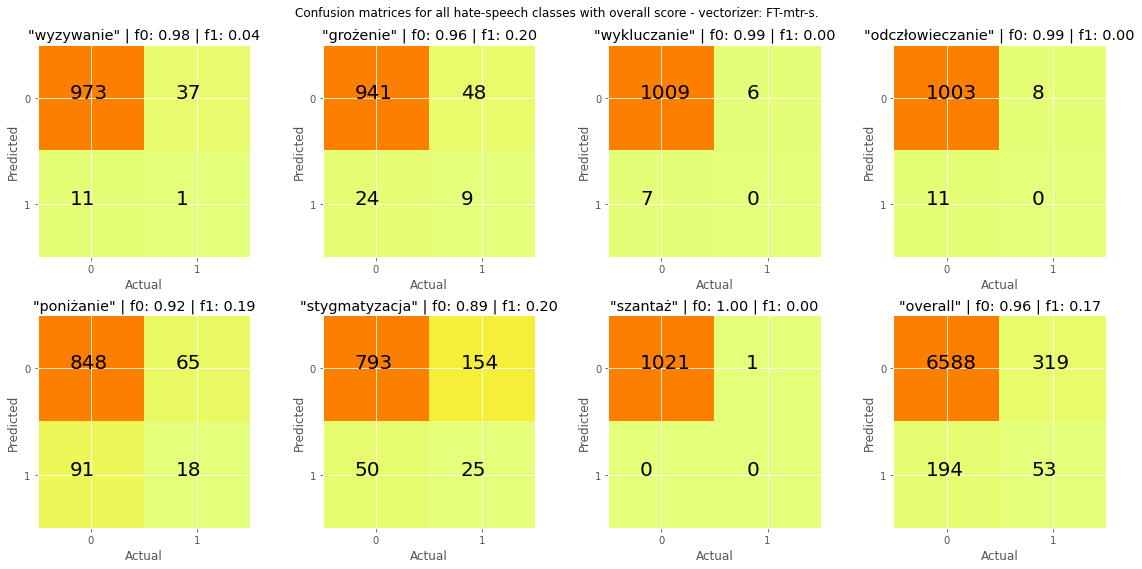

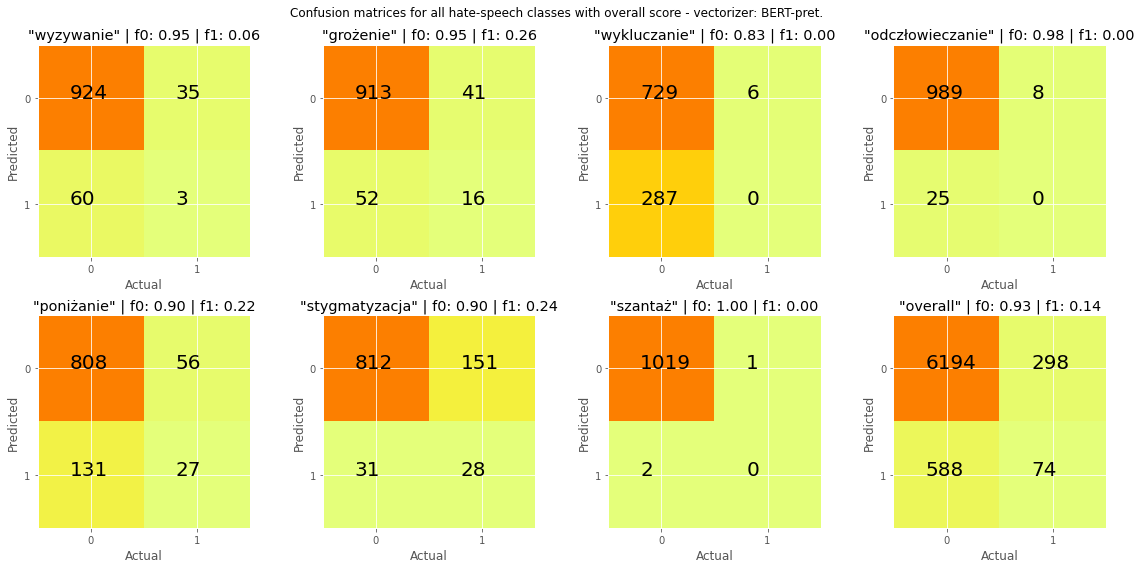

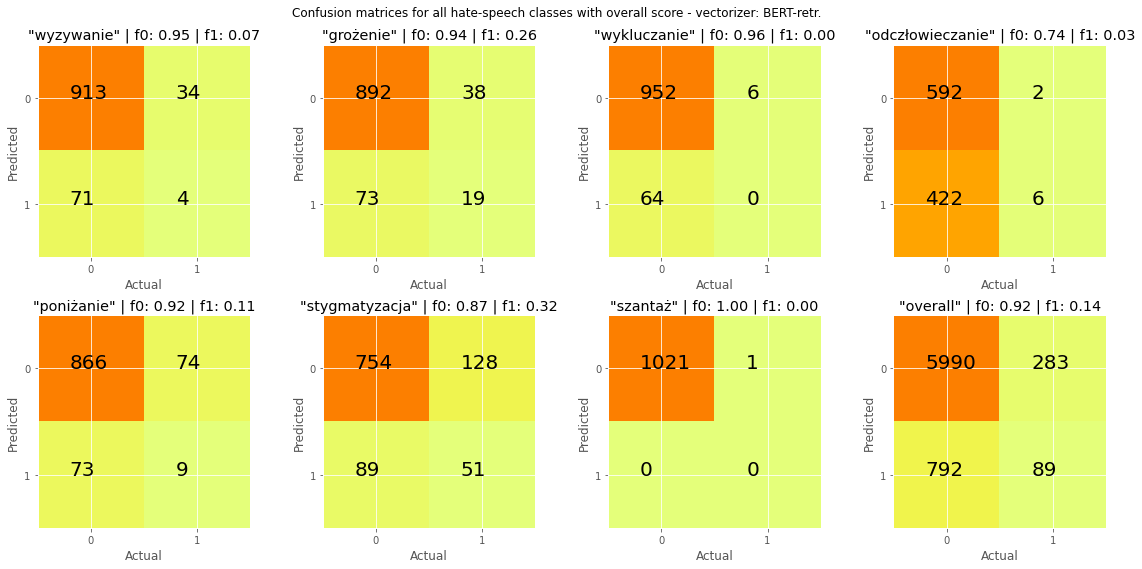

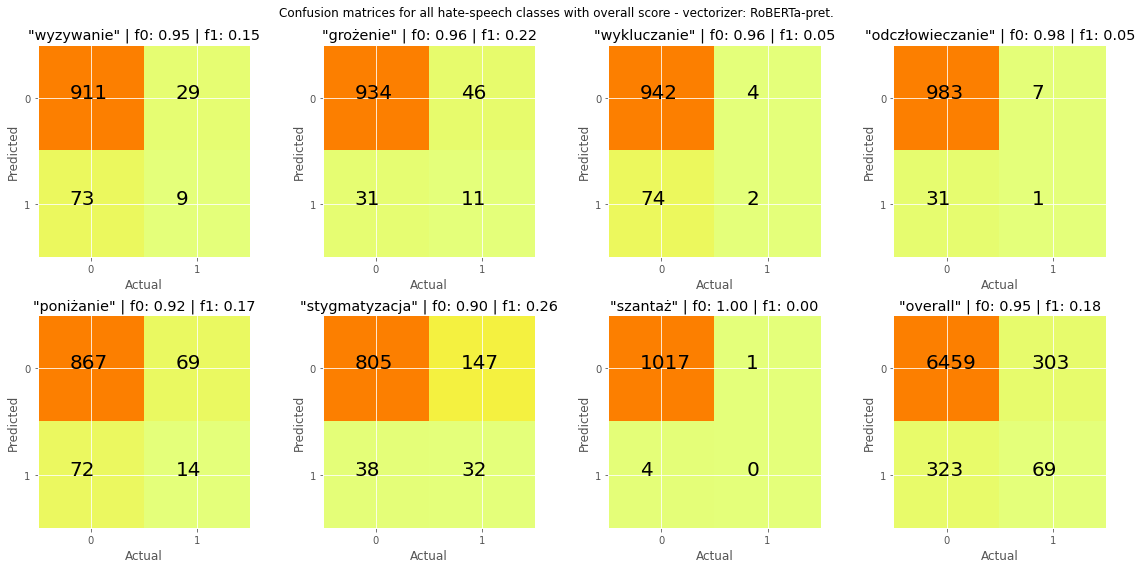

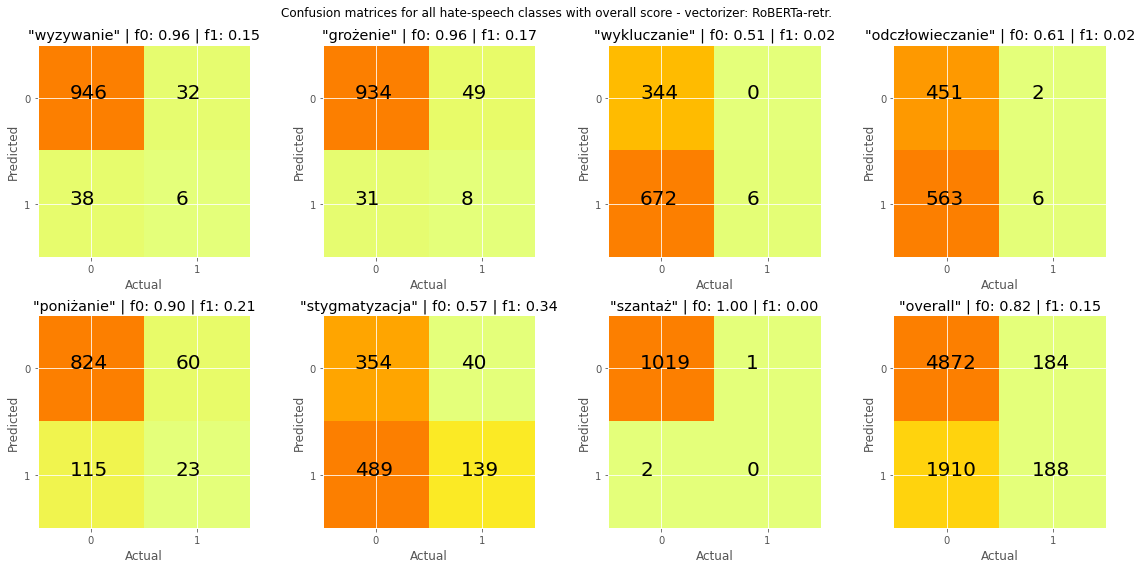

In [12]:
clf_kwargs = dict({'penalty': 'l2', 'class_weight': 'balanced'})
for vclass, vkwargs, vlabel in tqdm(zip(VEC_CLASSES, VEC_KWARGS, VEC_LABELS),
                                                   total=len(VEC_LABELS), leave=None):
    clf = SimpleMLVectorClassifier(k_folds=5, short_name=vlabel, vec_analysis=True,
                                   vec_class=vclass, clf_class=SGDClassifier,
                                   verbose=0, vec_kwargs=vkwargs, **clf_kwargs)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_test_data)
    confusion_matrices(y_test_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score - vectorizer: {vlabel}.',
                       save_file=SMLCV_CHART_DIR.replace('{}', f'confusion_matrices_{vlabel}'))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

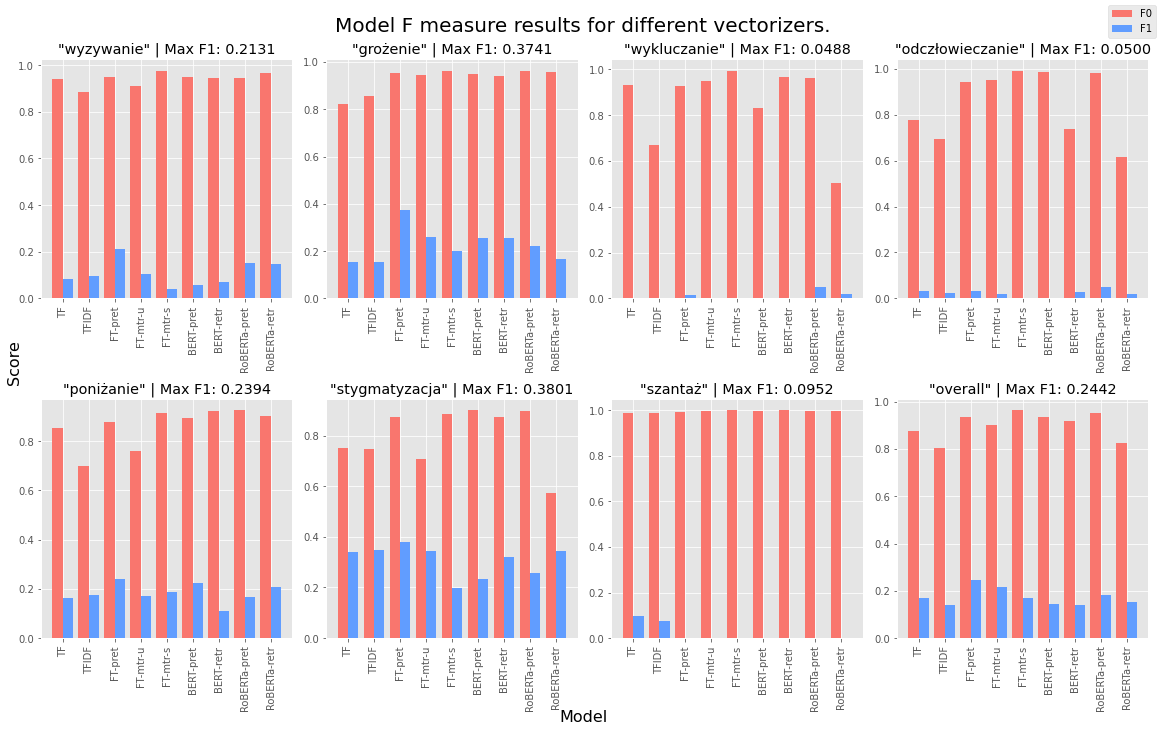

In [13]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='Model F measure results for different vectorizers.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=SMLCV_CHART_DIR.replace('{}', 'models_F_bars_2'))

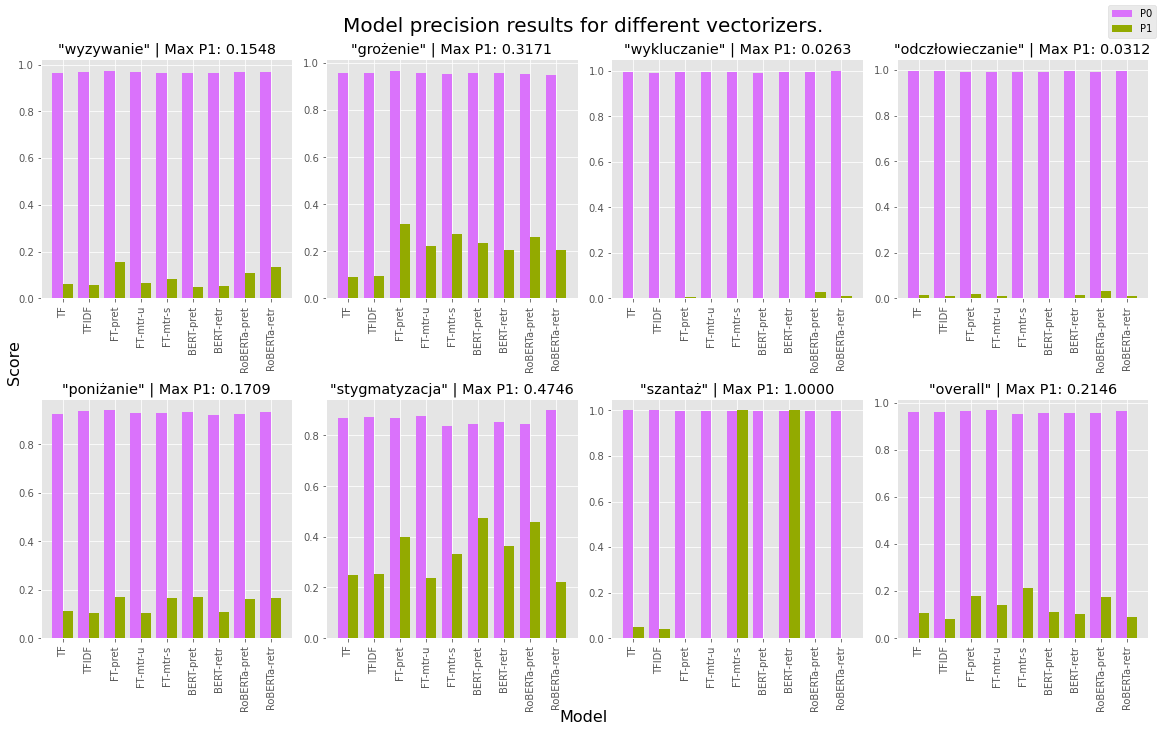

In [14]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='Model precision results for different vectorizers.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=SMLCV_CHART_DIR.replace('{}', 'models_P_bars_2'))

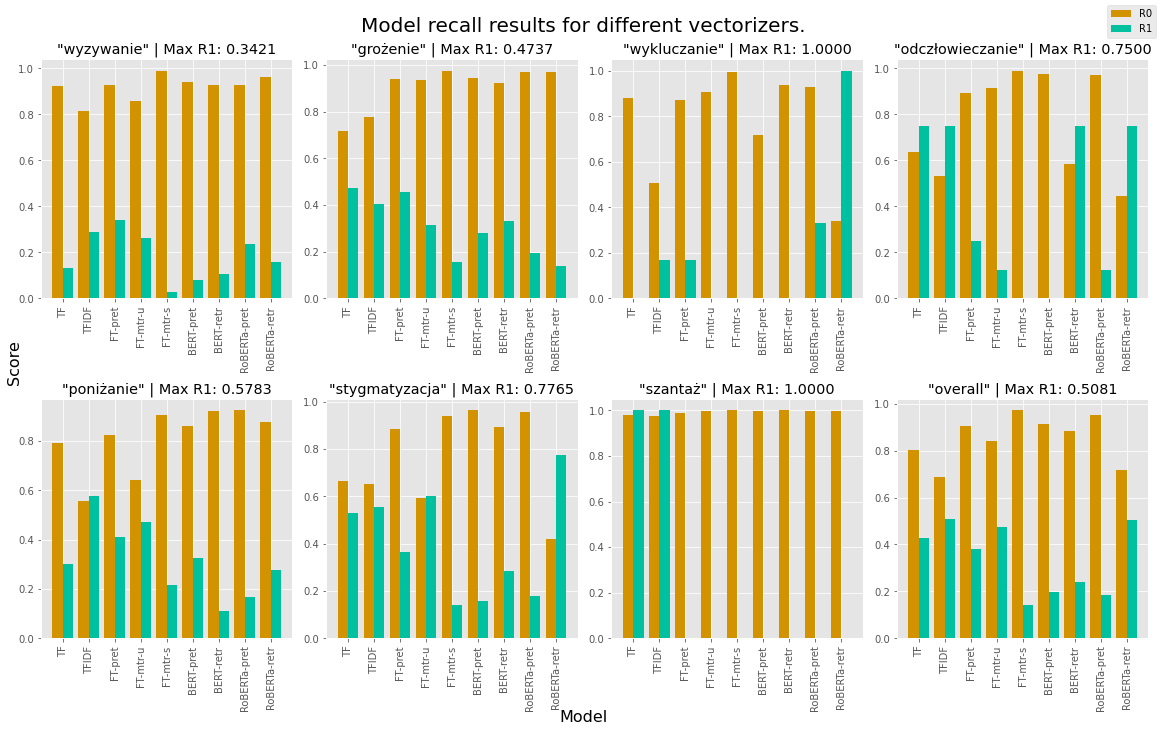

In [15]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='Model recall results for different vectorizers.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=SMLCV_CHART_DIR.replace('{}', 'models_R_bars_2'))

## Best vectorizer

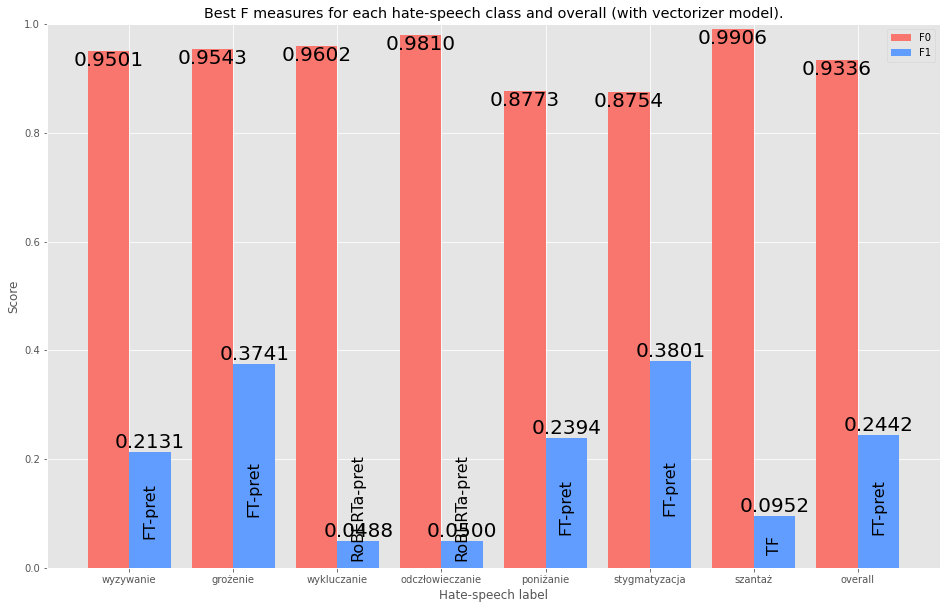

In [16]:
best_model_for_class(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                     title='Best F measures for each hate-speech class and overall (with vectorizer model).',
                     save_file=SMLCV_CHART_DIR.replace('{}', 'best_F_bars_2'))

Judging by the above two analyses the best vectorizer for classifier is **pretrained FastText vectorizer**.

In [21]:
vkwargs = dict({})
clf_kwargs = dict({'penalty': 'l2', 'class_weight': 'balanced'})
clf = SimpleMLVectorClassifier(k_folds=5, short_name='FT-pret', vec_analysis=True,
                               vec_class=TextPretrainedFTVectorizer, clf_class=SGDClassifier,
                               vec_kwargs=vkwargs, **clf_kwargs)
clf.load()

## Tests

### Test 1

In [22]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1.flatten()))

{'wyzywanie': 1,
 'grożenie': 1,
 'wykluczanie': 1,
 'odczłowieczanie': 1,
 'poniżanie': 1,
 'stygmatyzacja': 1,
 'szantaż': 0}

Empirically should be 'stygmatyzacja' and 'poniżanie' as positive. (**3/7 correct**)

### Test 2

In [23]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2.flatten()))

{'wyzywanie': 1,
 'grożenie': 1,
 'wykluczanie': 1,
 'odczłowieczanie': 1,
 'poniżanie': 1,
 'stygmatyzacja': 1,
 'szantaż': 0}

Empirically should be 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' as positive. (**5/7 correct**)

### Test 3

In [24]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3.flatten()))

{'wyzywanie': 0,
 'grożenie': 1,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'grożenie' as positive. (**7/7 correct**)